# Developing NIDS on normal dataset

To demonstrate the impact of adversarial attacks generated by our tool (NRT), we first train various machine learning-based Network Intrusion Detection Systems (NIDS) on a processed dataset file. Four distinct PCAPs—benign, dos_syn, ddos_icmp, and SQL injection—were processed using our UMNIDS tool to create a file named normal_data.csv. This file includes the processed flow, payload, and labels provided with the dataset.

In [24]:
import pandas as pd
df=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\normal_data.csv')

C:\Users\syedwali\AppData\Local\Temp\ipykernel_44248\3285948799.py:2: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\normal_data.csv')


In [25]:
df['label'].value_counts()

label
dos_syn      66201
benign       14892
sqli          2755
ddos_icmp      433
Name: count, dtype: int64

In [26]:
# Step 1: Get the count of instances per class
target_instances = 2500
# Step 2: Undersample or oversample each class to have exactly 2500 instances
balanced_df = pd.DataFrame()  # Empty dataframe to store balanced data

for label in df['label'].unique():
    class_subset = df[df['label'] == label]
    
    # If class has more than 2500 instances, undersample
    if len(class_subset) > target_instances:
        class_subset = class_subset.sample(target_instances, random_state=42)

    # Append the balanced class subset to the balanced dataframe
    balanced_df = pd.concat([balanced_df, class_subset])

# Reset index of the final balanced dataframe
df = balanced_df.reset_index(drop=True)
print(df['label'].value_counts())



label
benign       2500
dos_syn      2500
sqli         2500
ddos_icmp     433
Name: count, dtype: int64


Now, we will convert the udps.payload_data feature provided by the UM-NIDS tool into byte-level decimal values. This transformation will enable us to use the data to train various payload-based classifiers.


In [27]:
import ast

# Function to convert hex string into a list of integers at byte level (2 hex chars = 1 byte)
def hex_to_int_list_byte_level(hex_str):
    # Convert the string representation of a list to an actual list
    hex_list = ast.literal_eval(hex_str)
    int_list = []
    
    for hex_string in hex_list:
        # Split the hex string into 2-character chunks (1 byte = 2 hex chars)
        byte_chunks = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
        # Convert each byte (2 hex chars) into its decimal equivalent and append to list
        int_list.extend([int(byte, 16) for byte in byte_chunks])
    
    return int_list

# Apply this function to each entry in the 'udps.payload_data' column
df['udps.payload_data_converted'] = df['udps.payload_data'].apply(hex_to_int_list_byte_level)

# This will add a new column 'udps.payload_data_converted' with the byte-level decimal values


We will truncate or pad the payload data to ensure a fixed length, making it suitable for training classifiers.

In [28]:
import numpy as np

# Define the target length
target_length = 12000

# Function to truncate or pad the payload data
def truncate_or_pad(array):
    # Truncate if length is greater than target_length
    if len(array) > target_length:
        return array[:target_length]
    # Pad with zeros if length is less than target_length
    elif len(array) < target_length:
        return np.pad(array, (0, target_length - len(array)), 'constant')
    return array

# Apply the function to the payload data column
df['udps.payload_data_fixed'] = df['udps.payload_data_converted'].apply(truncate_or_pad)

# Now, df['udps.payload_data_fixed'] contains the truncated/padded arrays


## payload based NIDS

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
# Assuming df is already defined and has a 'label' column
X = np.array(df['udps.payload_data_fixed']).tolist()  # Features (drop the label column)
y = df['label']  # Labels

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the Random Forest Classifier
clf_payload = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)

# Train the classifier
clf_payload.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_payload.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

Accuracy: 0.9298
Classification Report:
              precision    recall  f1-score   support

      benign     0.9870    0.9621    0.9744       791
   ddos_icmp     0.5833    0.3307    0.4221       127
     dos_syn     0.9465    0.9918    0.9686       732
        sqli     0.8883    0.9370    0.9120       730

    accuracy                         0.9298      2380
   macro avg     0.8513    0.8054    0.8193      2380
weighted avg     0.9228    0.9298    0.9240      2380



In [30]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf_gbm.fit(X_train, y_train)
y_pred_gbm = clf_gbm.predict(X_test)

accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f'Gradient Boosting Accuracy: {accuracy_gbm:.5f}')
print(classification_report(y_test, y_pred_gbm,digits=4))


Gradient Boosting Accuracy: 0.93529
              precision    recall  f1-score   support

      benign     0.9896    0.9621    0.9756       791
   ddos_icmp     0.7447    0.2756    0.4023       127
     dos_syn     0.9429    0.9918    0.9667       732
        sqli     0.8866    0.9644    0.9239       730

    accuracy                         0.9353      2380
   macro avg     0.8909    0.7985    0.8171      2380
weighted avg     0.9306    0.9353    0.9264      2380



In [31]:
y_train2 = y_train.map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2,'sqli':3})
y_test2 = y_test.map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2,'sqli':3})

In [32]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)
clf_xgb.fit(X_train, y_train2)
y_pred_xgb = clf_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test2, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.5f}')
print(classification_report(y_test2, y_pred_xgb,digits=4))


XGBoost Accuracy: 0.92731
              precision    recall  f1-score   support

           0     0.9896    0.9608    0.9750       791
           1     0.9465    0.9918    0.9686       732
           2     0.5248    0.4173    0.4649       127
           3     0.8978    0.9151    0.9064       730

    accuracy                         0.9273      2380
   macro avg     0.8397    0.8213    0.8287      2380
weighted avg     0.9234    0.9273    0.9248      2380



In [34]:
import lightgbm as lgb

clf_lgb = lgb.LGBMClassifier(n_estimators=100, random_state=42)
clf_lgb.fit(X_train, y_train2)
y_pred_lgb = clf_lgb.predict(X_test)

accuracy_lgb = accuracy_score(y_test2, y_pred_lgb)
print(f'LightGBM Accuracy: {accuracy_lgb:.5f}')
print(classification_report(y_test2, y_pred_lgb,digits=4))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476831
[LightGBM] [Info] Number of data points in the train set: 5553, number of used features: 12000
[LightGBM] [Info] Start training from score -1.178430
[LightGBM] [Info] Start training from score -1.144489
[LightGBM] [Info] Start training from score -2.898508
[LightGBM] [Info] Start training from score -1.143359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.92815
              precision    recall  f1-score   support

           0     0.9909    0.9621    0.9763       791
           1     0.9453    0.9918    0.9680       732
           2     0.5243    0.4252    0.4696       127
           3     0.9015    0.9151    0.9082       730

    accuracy                         0.9282      2380

In [33]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'MLP Accuracy: {accuracy_mlp:.5f}')
print(classification_report(y_test, y_pred_mlp,digits=4))


MLP Accuracy: 0.90042
              precision    recall  f1-score   support

      benign     0.9920    0.9393    0.9649       791
   ddos_icmp     0.3019    0.2520    0.2747       127
     dos_syn     0.9465    0.9904    0.9680       732
        sqli     0.8472    0.8808    0.8637       730

    accuracy                         0.9004      2380
   macro avg     0.7719    0.7656    0.7678      2380
weighted avg     0.8967    0.9004    0.8980      2380



### Adversarial Testing

We used the PCAPs (ddos_icmp and dos_syn) from the CIC-IoT23 dataset as input to the NRT tool to modify the payload. The modified PCAPs were then processed with the UM-NIDS tool to convert them into a CSV file named payload_attacks.csv. We are now reading the payload data from this CSV to evaluate the extent to which these adversarial samples successfully evade the classifiers.

In [35]:
def balancer(df,target_instances):
    # Empty dataframe to store balanced data
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        class_subset = df[df['label'] == label]
        
        # If class has more than 2500 instances, undersample
        if len(class_subset) > target_instances:
            class_subset = class_subset.sample(target_instances, random_state=42)
        
        # Append the balanced class subset to the balanced dataframe
        balanced_df = pd.concat([balanced_df, class_subset])
    return balanced_df.reset_index(drop=True)

In [36]:
df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\Payload Only\\payload_attacks.csv')
target_instances = 500
df2 = balancer(df2,target_instances)
print(df2['label'].value_counts())

C:\Users\syedwali\AppData\Local\Temp\ipykernel_44248\3515034534.py:1: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\Payload Only\\payload_attacks.csv')


label
dos_syn      500
ddos_icmp    457
Name: count, dtype: int64


In [37]:
df2['udps.payload_data_converted'] = df2['udps.payload_data'].apply(hex_to_int_list_byte_level)

In [38]:
df2['udps.payload_data_fixed'] = df2['udps.payload_data_converted'].apply(truncate_or_pad)


Classifier: Random Forest
**************************************************
Classification Report:
              precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         0
   ddos_icmp     1.0000    0.7549    0.8603       457
     dos_syn     0.0000    0.0000    0.0000       500
        sqli     0.0000    0.0000    0.0000         0

    accuracy                         0.3605       957
   macro avg     0.2500    0.1887    0.2151       957
weighted avg     0.4775    0.3605    0.4108       957



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

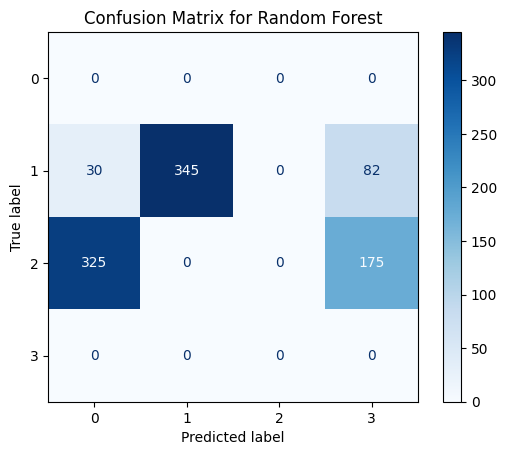


Classifier: Gradient Boosting
**************************************************
Classification Report:
              precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         0
   ddos_icmp     1.0000    0.4770    0.6459       457
     dos_syn     0.0000    0.0000    0.0000       500
        sqli     0.0000    0.0000    0.0000         0

    accuracy                         0.2278       957
   macro avg     0.2500    0.1193    0.1615       957
weighted avg     0.4775    0.2278    0.3085       957



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


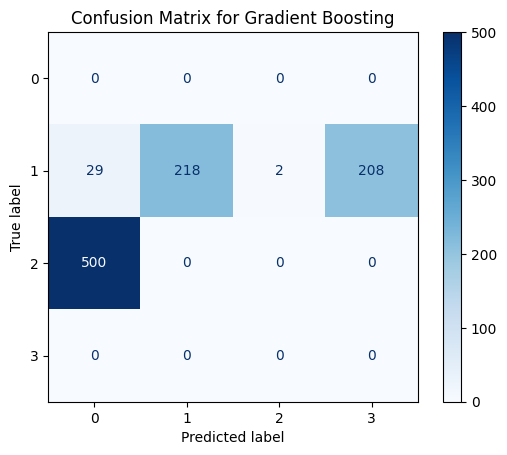


Classifier: XGB
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     1.0000    0.7790    0.8758       457
           3     0.0000    0.0000    0.0000         0

    accuracy                         0.3720       957
   macro avg     0.2500    0.1947    0.2189       957
weighted avg     0.4775    0.3720    0.4182       957



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

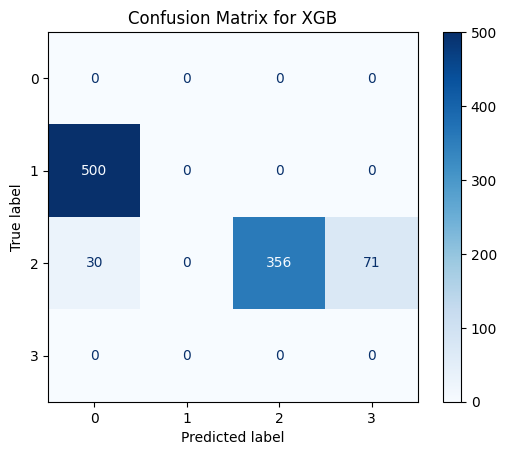


Classifier: LGB
**************************************************


C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     1.0000    0.7812    0.8771       457
           3     0.0000    0.0000    0.0000         0

    accuracy                         0.3730       957
   macro avg     0.2500    0.1953    0.2193       957
weighted avg     0.4775    0.3730    0.4189       957



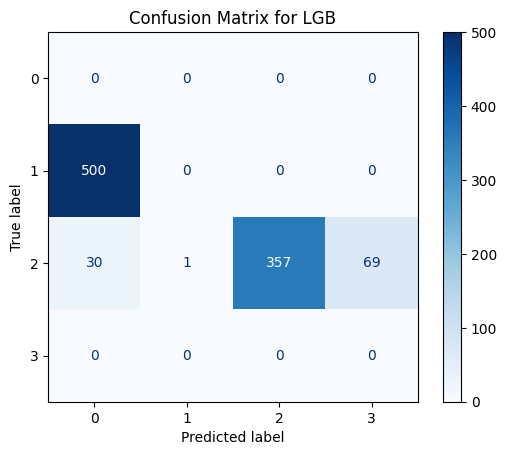


Classifier: MLP
**************************************************
Classification Report:
              precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         0
   ddos_icmp     1.0000    0.2998    0.4613       457
     dos_syn     0.0000    0.0000    0.0000       500
        sqli     0.0000    0.0000    0.0000         0

    accuracy                         0.1432       957
   macro avg     0.2500    0.0749    0.1153       957
weighted avg     0.4775    0.1432    0.2203       957



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

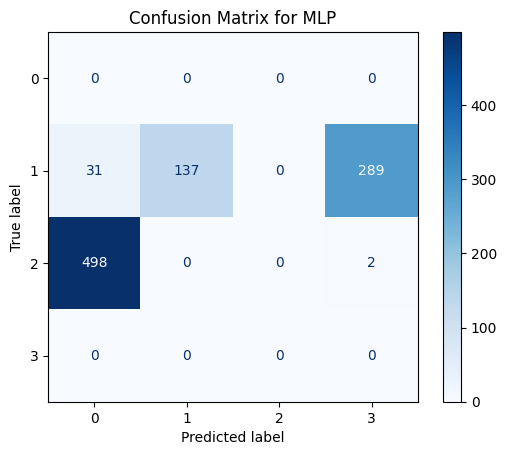

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
X = np.array(df2['udps.payload_data_fixed']).tolist()  # Features (drop the label column)
y = df2['label']  # Labels
y2 = y.map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2,'sqli':3})
# List of trained classifiers with their names for easy iteration
classifiers = {
    "Random Forest": clf_payload,
    "Gradient Boosting": clf_gbm,
    "XGB": clf_xgb,
    "LGB": clf_lgb,
    "MLP": clf_mlp,    
}

# Iterate through each classifier, predict, and print results
for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    print("*"*50)
    try:
        # Predict on the test set
        y_pred = clf.predict(X)
        # Evaluate the model
        report = classification_report(y, y_pred, digits=4)
        cm = confusion_matrix(y, y_pred)
    except:
         # Predict on the test set
        y_pred = clf.predict(X)
        # Evaluate the model
        report = classification_report(y2, y_pred, digits=4)
        cm = confusion_matrix(y2, y_pred)
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
